# Predicting lender retention

- We create panda data frames using SQL queries (data is small enough to load in the data we need in to memory)
- We do feature engineering to find useful features from the data
- We implement logistic regression model with regularization, and random forest model to identify the most important features
- As random forest was best model, we re-run this model with 100 most predictive features to prevent overfitting; and from this model we end up chosing the 20 most predictive features.

## Main findings
- Most important features are:
'usd invested in first week', 'number of loans in first week', 'deactivated auto lending', 'subjectivity score', 'avg comment length', 'polarity score', 'gift card giver', 'received comments in first week', 'inviter'
- Other predictive features are certain words, most regarding borrowers being thankful for lenders contributions. Grouping words into topics could potentially yield individually more predictive features.
- Certain comments characteristics are likely to have a higher retention rate. We expect retention rate to go up if all comments are in line with the "best" characteristics.
- A lender is 10% more likely to retain if he gets a comment within the week of his first loan.

## Importing all packages that are needed

In [1]:
import datetime
import mysql.connector
import numpy as np
from collections import Counter
import pandas as pd
%matplotlib inline
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from textblob import TextBlob
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from ggplot import *
import seaborn as sns
import time
import json
from pprint import pprint

## Define some useful functions

In [2]:
def get_subjectivity(text):
    ''' Function that calculates a subjectivity score of a text'''
    return TextBlob(text).sentiment[1]

In [3]:
def get_polarity(text):
    ''' Function that calculates a polarity score of a text'''
    return TextBlob(text).sentiment[0]

In [4]:
def review_to_words( raw_review ):
    ''' Function to convert a raw review to a string of words
    The input is a single string (a raw movie review), and 
    he output is a single string (a preprocessed movie review) '''
    
    # 1. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review) 
    
    # 2. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    
    # 3. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
     
    # 4. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    
    # 5. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words )) 

## Create panda data frames from SQL queries

In [5]:
with open('auth.json') as data_file:    
    auth_info = json.load(data_file)

In [6]:
cnx = mysql.connector.connect(user=auth_info['username'], password=auth_info['password'],
                              host=auth_info['ip'],
                              database=auth_info['db'])

In [7]:
cur_lenders = cnx.cursor(buffered=True)
lenders_query = ("SELECT id,country_id,created_at FROM lenders")
cur_lenders.execute(lenders_query)
lenders_data = cur_lenders.fetchall()
column_names_lenders = ['id', 'country_id', 'created_at']
lenders_df = pd.DataFrame(lenders_data, columns=column_names_lenders)

In [8]:
cur_transactions = cnx.cursor(buffered=True)
transactions_query = ("SELECT id,user_id,amount,loan_id,transaction_date FROM transactions WHERE type = 1")
cur_transactions.execute(transactions_query)
transactions_data = cur_transactions.fetchall()
column_names_transactions = ['id','user_id','amount','loan_id','transaction_date']
transactions_df = pd.DataFrame(transactions_data, columns=column_names_transactions)

In [9]:
cur_countries = cnx.cursor(buffered=True)
countries_query = ("SELECT id,name,country_code FROM countries")
cur_countries.execute(countries_query)
countries_data = cur_countries.fetchall()
column_names_countries = ['id','name','country_code']
countries_df = pd.DataFrame(countries_data, columns=column_names_countries)

In [10]:
cur_invites = cnx.cursor(buffered=True)
invites_query = ("SELECT id,lender_id,invitee_id,created_at,updated_at FROM lender_invites")
cur_invites.execute(invites_query)
invites_data = cur_invites.fetchall()
column_names_invites = ['id','lender_id','invitee_id','created_at','updated_at']
invites_df = pd.DataFrame(invites_data, columns=column_names_invites)

In [11]:
cur_giftcard = cnx.cursor(buffered=True)
giftcard_query = ("SELECT id,lender_id,recipient_id,date FROM gift_cards")
cur_giftcard.execute(giftcard_query)
giftcard_data = cur_giftcard.fetchall()
column_names_giftcards = ['id','lender_id','recipient_id','date']
giftcards_df = pd.DataFrame(giftcard_data, columns=column_names_giftcards)

In [12]:
cur_auto_lending = cnx.cursor(buffered=True)
auto_lending_query = ("SELECT id,lender_id,active FROM auto_lending_settings")
cur_auto_lending.execute(auto_lending_query)
auto_lending_data = cur_auto_lending.fetchall()
column_names_auto_lending = ['id','lender_id','active']
auto_lending_df = pd.DataFrame(auto_lending_data, columns=column_names_auto_lending)

In [13]:
cur_loan_bids = cnx.cursor(buffered=True)
loan_bids_query = ("SELECT id,loan_id,lender_id,borrower_id,bid_amount,accepted_amount,bid_at FROM loan_bids")
cur_loan_bids.execute(loan_bids_query)
loan_bids_data = cur_loan_bids.fetchall()
column_names_loan_bids = ['id','loan_id','lender_id','borrower_id','bid_amount','accepted_amount','bid_at']
loan_bids_df = pd.DataFrame(loan_bids_data, columns=column_names_loan_bids)

In [14]:
cur_borrower_comments = cnx.cursor(buffered=True)
borrower_comments_query = ("SELECT borrower_id,id,user_id,message FROM borrower_comments")
cur_borrower_comments.execute(borrower_comments_query)
borrower_comments_data = cur_borrower_comments.fetchall()
column_names_borrower_comments = ['borrower_id','id','user_id','message']
borrower_comments_df = pd.DataFrame(borrower_comments_data, columns=column_names_borrower_comments)

In [15]:
cur_installments = cnx.cursor(buffered=True)
installments_query = ("SELECT id,borrower_id,loan_id,due_date,amount,paid_date,paid_amount,amount_usd,paid_amount_usd FROM installments")
cur_installments.execute(installments_query)
installments_data = cur_installments.fetchall()
column_names_installments = ['id','borrower_id','loan_id','due_date','amount','paid_date','paid_amount','amount_usd','paid_amount_usd']
installments_df = pd.DataFrame(installments_data, columns=column_names_installments)

## Set up a bunch of useful maps

In [16]:
map_countryid_country = {}
for i in range(0,len(countries_df)):
    map_countryid_country[countries_df.id[i]] = countries_df.name[i]

In [17]:
map_countryid_numlenders = {}
for i in range(0,len(countries_df)):
    map_countryid_numlenders[countries_df.id[i]] = 0
for i in range(0,len(lenders_df.country_id)):
    map_countryid_numlenders[lenders_df.country_id[i]] += 1 

In [18]:
map_country_numlenders = {}
for i in range(0,len(countries_df)):
    map_country_numlenders[countries_df.name[i]] = 0
for i in range(0,len(lenders_df.country_id)):
    map_country_numlenders[map_countryid_country[lenders_df.country_id[i]]] += 1 

In [19]:
map_countryid_countrycode = {}
for i in range(0,len(countries_df)):
    map_countryid_countrycode[countries_df.id[i]] = countries_df.country_code[i]

In [20]:
map_countrycode_numlenders = {}
for i in range(0,len(countries_df)):
    map_countrycode_numlenders[countries_df.country_code[i]] = 0
for i in range(0,len(lenders_df.country_id)):
    map_countrycode_numlenders[map_countryid_countrycode[lenders_df.country_id[i]]] += 1 

In [21]:
map_id_rownumber = {}
for i in range(0,len(lenders_df)):
    map_id_rownumber[lenders_df.id[i]] = i

In [22]:
map_id_firstupload = {}
for i in range(0,len(transactions_df)):
    try:
        usr_id = transactions_df.loc[i,'user_id']
        map_id_firstupload[usr_id] = min(map_id_firstupload[usr_id],transactions_df.loc[i,'transaction_date'])
    except KeyError:
        map_id_firstupload[usr_id] = transactions_df.loc[i,'transaction_date']

## Label users as retained or not retained

In [23]:
userid_numtrans_dict = {}
userid_datestrans_dict = {}
for i in range(0,len(transactions_df)):
    try:
        userid_datestrans_dict[transactions_df.user_id[i]].append(transactions_df.transaction_date[i])
        userid_numtrans_dict[transactions_df.user_id[i]] += 1
    except KeyError:
        userid_datestrans_dict[transactions_df.user_id[i]] = [transactions_df.transaction_date[i]]
        userid_numtrans_dict[transactions_df.user_id[i]] = 1

In [24]:
lenders_df['num_upload_transactions'] = 0
for i in range(0,len(lenders_df)):
    try:
        lenders_df.loc[i,('num_upload_transactions')] = userid_numtrans_dict[lenders_df.id[i]]
    except KeyError:
        lenders_df.loc[i,('num_upload_transactions')] = 0

In [25]:
lenders_df['retained'] = (lenders_df['num_upload_transactions'] > 1) + 0
lenders_df['never_uploaded'] = (lenders_df['num_upload_transactions'] == 0) + 0

In [26]:
retained_df = lenders_df[lenders_df.retained==1]
uploaded_df = lenders_df[lenders_df.never_uploaded==0]

## Feature type 1: Is invited/not invited predictive of lender retention
### Feature: invited

In [27]:
idx = invites_df['invitee_id'].dropna()

In [28]:
lenders_df['invited'] = 0
for val in idx:
    lenders_df.loc[map_id_rownumber[val],('invited')] = 1

## Feature type 2: Is inviter/not inviter predictive of lender retention
### Feature: inviter

In [29]:
idx2 = invites_df['lender_id'].dropna()

In [30]:
lenders_df['inviter'] = 0
for val in idx2:
    lenders_df.loc[map_id_rownumber[val],('inviter')] = 1

## Feature type 3: Is joining through gift card predictive of lender retention
### Feature: gift_card

In [31]:
idx = giftcards_df.recipient_id.dropna()

In [32]:
recipient_df = giftcards_df[giftcards_df.recipient_id.notnull()]

In [33]:
recipient_df = giftcards_df[giftcards_df.recipient_id.notnull()]
recipient_df = recipient_df.loc[:,['date','recipient_id']]
recipient_df['lender_id'] = recipient_df['recipient_id']
recipient_df = recipient_df.drop('recipient_id',1)
temp_lenders_df = lenders_df.loc[:,['id','created_at']]
temp_lenders_df['lender_id'] = temp_lenders_df['id']
temp_lenders_df = temp_lenders_df.drop('id',1)
dates_df = pd.merge(recipient_df,temp_lenders_df.loc[:,['lender_id','created_at']],on='lender_id')
dates_df['date_diff'] = dates_df.created_at - dates_df.date

In [34]:
#(dates_df[(dates_df['date_diff'] < pd.Timedelta('365 days'))])
shorter_dates_df = (dates_df[(dates_df['date_diff'] < pd.Timedelta('365 days')) & (dates_df['date_diff'] > pd.Timedelta('-7 days'))])
shorter_dates_df = (shorter_dates_df[shorter_dates_df.created_at != '2014-10-04 06:32:30'])
shorter_dates_df = (shorter_dates_df[shorter_dates_df.created_at != '2014-10-04 06:32:31'])
shorter_dates_df = (shorter_dates_df[shorter_dates_df.created_at != '2014-10-04 06:32:32'])
shorter_dates_df = (shorter_dates_df[shorter_dates_df.created_at != '2014-10-04 06:32:33'])
idx3 = shorter_dates_df.lender_id

In [35]:
lenders_df['gift_card'] = 0
for val in idx3:
    lenders_df.loc[map_id_rownumber[val],('gift_card')] = 1


## Feature type 4: Is gift card giving predictive of lender retention
### Feature: gift_card_giver

In [36]:
idx2 = giftcards_df.lender_id.dropna()

In [37]:
lenders_df['gift_card_giver'] = 0
for val in idx2:
    lenders_df.loc[map_id_rownumber[val],('gift_card_giver')] = 1

## Feature type 5: Is disabling of auto lending predictive of lender retention
### Features: active_auto_lending, nonactive_auto_lending

In [38]:
active_auto_lending_id = auto_lending_df[auto_lending_df.active == 1].lender_id
nonactive_auto_lending_id = auto_lending_df[auto_lending_df.active == 0].lender_id

In [39]:
lenders_df['active_auto_lending'] = 0
lenders_df['nonactive_auto_lending'] = 0
for val in active_auto_lending_id:
    lenders_df.loc[map_id_rownumber[val],('active_auto_lending')] = 1
for val in nonactive_auto_lending_id:
    lenders_df.loc[map_id_rownumber[val],('nonactive_auto_lending')] = 1

## Feature type 6: Does number of loans in first month (or in first week) predict lender retention
### Features: loans_in_first_week, usd_in_first_week

In [40]:
firstupload_df = pd.DataFrame(map_id_firstupload.items(), columns=['lender_id', 'first_transaction_date'])

In [41]:
### Takes a while to run
lenders_df['number_of_loans'] = 0

for row in range(0,len(loan_bids_df)):
    lender_id = loan_bids_df.lender_id[row]
    lenders_df.loc[map_id_rownumber[lender_id],('number_of_loans')] += 1
    

In [42]:
lenders_df_temp = lenders_df.loc[:,('id','created_at')]
lenders_df_temp['lender_id'] = lenders_df_temp['id']
lenders_df_temp = lenders_df_temp.drop('id',1)

In [43]:
loan_bids_df_temp = loan_bids_df.loc[loan_bids_df.accepted_amount != 0,('lender_id','accepted_amount','bid_at')]

In [44]:
lend_loan_df = pd.merge(loan_bids_df_temp,firstupload_df,on='lender_id')

In [45]:
lend_loan_df['time_diff'] = lend_loan_df.bid_at - lend_loan_df.first_transaction_date

In [46]:
lend_loan_week_df = lend_loan_df[(lend_loan_df['time_diff'] > pd.Timedelta('0 days')) & (lend_loan_df['time_diff'] < pd.Timedelta('7 days'))]
lend_loan_month_df = lend_loan_df[(lend_loan_df['time_diff'] > pd.Timedelta('0 days')) & (lend_loan_df['time_diff'] < pd.Timedelta('31 days'))]

In [47]:
lenders_df['loans_in_first_week'] = 0
lenders_df['usd_in_first_week'] = 0

for row in lend_loan_week_df.index:
    lender_id = lend_loan_week_df.lender_id[row]
    lenders_df.loc[map_id_rownumber[lender_id],('loans_in_first_week')] += 1
    lenders_df.loc[map_id_rownumber[lender_id],('usd_in_first_week')] += lend_loan_week_df.accepted_amount[row]


In [48]:
lenders_df = lenders_df.drop('number_of_loans',1)

## Feature type 7: Does comments after loan predict lender retention, and which comments matter
### Features: comments_within_week,polarity_score, subjectivity_score,avg_comment_length

In [50]:
borrower_comments_df['polarity'] = borrower_comments_df.message.apply(get_polarity)

In [51]:
borrower_comments_df['subjectivity'] = borrower_comments_df.message.apply(get_subjectivity)

In [52]:
borrower_comments_df['comment_length'] = borrower_comments_df.loc[:,'message'].apply(nltk.word_tokenize).apply(len)

In [53]:
#Takes a minute to compute, but faster than for example loading in everything and doing the "Where" with python
cur_loan_comment = cnx.cursor(buffered=True)
loan_comment_query = ("select loan_bids.lender_id,loan_bids.borrower_id,loan_bids.bid_at,borrower_comments.created_at,borrower_comments.id from loan_bids INNER JOIN borrower_comments ON loan_bids.borrower_id=borrower_comments.borrower_id where loan_bids.bid_at < borrower_comments.created_at AND DATEDIFF(borrower_comments.created_at,loan_bids.bid_at) < 7;")
cur_loan_comment.execute(loan_comment_query)
loan_comment_data = cur_loan_comment.fetchall()
column_names_loan_comment = ['lender_id','borrower_id','bid_at','created_at','id']
loan_comment_df = pd.DataFrame(loan_comment_data, columns=column_names_loan_comment)

In [54]:
loans_comment_within_week = loan_comment_df

In [55]:
firstupload_df = pd.DataFrame(map_id_firstupload.items(), columns=['lender_id', 'first_transaction_date'])

In [56]:
loans_comment_within_week = pd.merge(loans_comment_within_week,firstupload_df,on='lender_id')

In [57]:
loans_comment_within_week['upload_prior_loan'] = (loans_comment_within_week['first_transaction_date'] < loans_comment_within_week['bid_at'])+0

In [58]:
loans_comment_within_week.loc[:,'loan_within_week'] = (loans_comment_within_week.bid_at - loans_comment_within_week.first_transaction_date < pd.Timedelta('7 days'))+0

In [59]:
loans_comment_within_week = pd.merge(loans_comment_within_week,borrower_comments_df.loc[:,('id','polarity','subjectivity','comment_length')],on='id')

In [60]:
lenders_loan_comment_within_week = loans_comment_within_week.loc[loans_comment_within_week['loan_within_week'] == 1,('lender_id')]
polarity_lenders_loan_comment_within_week = loans_comment_within_week.loc[(loans_comment_within_week['loan_within_week'] == 1) ,('lender_id','polarity')]
subjectivity_lenders_loan_comment_within_week = loans_comment_within_week.loc[(loans_comment_within_week['loan_within_week'] == 1) ,('lender_id','subjectivity')]
comment_length_lenders_loan_comment_within_week = loans_comment_within_week.loc[(loans_comment_within_week['loan_within_week'] == 1) ,('lender_id','comment_length')]

In [61]:
unique_within_week = lenders_loan_comment_within_week.unique()

In [62]:
lenders_df['comments_within_week'] = 0
for i in lenders_loan_comment_within_week.index:
    row_i = map_id_rownumber[lenders_loan_comment_within_week[i]]
    lenders_df.loc[row_i,('comments_within_week')] += 1

In [63]:
lenders_df['polarity_within_week'] = 0
for i in polarity_lenders_loan_comment_within_week.index:
    row_i = map_id_rownumber[polarity_lenders_loan_comment_within_week.loc[i,'lender_id']]
    lenders_df.loc[row_i,('polarity_within_week')] += polarity_lenders_loan_comment_within_week.loc[i,'polarity']

In [64]:
lenders_df['subjectivity_within_week'] = 0
for i in subjectivity_lenders_loan_comment_within_week.index:
    row_i = map_id_rownumber[subjectivity_lenders_loan_comment_within_week.loc[i,'lender_id']]
    lenders_df.loc[row_i,('subjectivity_within_week')] += subjectivity_lenders_loan_comment_within_week.loc[i,'subjectivity']

In [65]:
lenders_df['comment_length_within_week'] = 0
for i in comment_length_lenders_loan_comment_within_week.index:
    row_i = map_id_rownumber[comment_length_lenders_loan_comment_within_week.loc[i,'lender_id']]
    lenders_df.loc[row_i,('comment_length_within_week')] += comment_length_lenders_loan_comment_within_week.loc[i,'comment_length']

In [66]:
lenders_df['polarity_score'] = lenders_df['polarity_within_week'] / lenders_df['comments_within_week']
lenders_df['subjectivity_score'] = lenders_df['subjectivity_within_week'] / lenders_df['comments_within_week']
lenders_df['avg_comment_length'] = lenders_df['comment_length_within_week'] / lenders_df['comments_within_week']

In [67]:
lenders_df = lenders_df.drop('polarity_within_week',1)
lenders_df = lenders_df.drop('subjectivity_within_week',1)

## Feature type 8: Bag of words features
### Features: 1000 most frequent words

In [68]:
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 1000) 

In [69]:
borrower_comments_df.loc[:,'clean_message'] = borrower_comments_df.loc[:,'message'].apply(review_to_words)

In [70]:
top_words = vectorizer.fit_transform(borrower_comments_df.loc[:,'clean_message'].tolist())

In [71]:
top_words = top_words.toarray()

In [72]:
top_words_df = pd.DataFrame(top_words,columns=vectorizer.get_feature_names())

In [73]:
top_words_df[:2]

,able,abundantly,accept,access,account,acheter,achieve,activit,actually,ada,...,wrong,www,yang,year,years,yes,yesterday,yet,young,zidisha
0,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,3
1,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,3


In [74]:
borrower_words_df = pd.concat([borrower_comments_df['id'],top_words_df],axis=1)

In [75]:
merged_df = pd.merge(loans_comment_within_week,borrower_words_df,on='id')

In [76]:
lenders_loan_words_within_week = merged_df.loc[merged_df['loan_within_week'] == 1,:]


In [77]:
lenders_loan_words_within_week[:2]

,lender_id,borrower_id,bid_at,created_at,id,first_transaction_date,upload_prior_loan,loan_within_week,polarity,subjectivity,...,wrong,www,yang,year,years,yes,yesterday,yet,young,zidisha
3,182,147,2010-01-28 02:37:53,2010-01-30 05:46:05,25,2010-01-27 06:22:03,1,1,1.0,0.3,...,0,0,0,0,0,0,0,0,0,0
4,181,147,2010-01-28 21:40:12,2010-01-30 05:46:05,25,2010-01-28 21:32:44,1,1,1.0,0.3,...,0,0,0,0,0,0,0,0,0,0


In [78]:
grouped_lenders_loan_words_within_week = lenders_loan_words_within_week.groupby('lender_id')

In [79]:
words_by_lender_id = grouped_lenders_loan_words_within_week.sum()

In [80]:
words_by_lender_id['lender_id'] = words_by_lender_id.index

In [81]:
test_df = lenders_df
test_df['lender_id'] = test_df['id']
test_df = test_df.drop('id',1)

In [82]:
test_df = pd.merge(test_df,words_by_lender_id,on='lender_id',how='left')

In [83]:
test_df.loc[:,'invited_orig'] = test_df.invited_x
test_df.loc[:,'invited'] = test_df.invited_y
test_df = test_df.drop('invited_x',1)
test_df = test_df.drop('invited_y',1)

In [84]:
a = test_df.ix[:,words_by_lender_id.columns.tolist()].fillna(0)
test_df.ix[:,words_by_lender_id.columns.tolist()] = a

In [85]:
lenders_df = test_df

## Preparing input for ML Algorithms
- X is the dataframe containing all the features
- y is the vector we want to predict
- Data is split into train (70%) and test (30%) sets

In [86]:
#X = lenders_df.loc[lenders_df['never_uploaded']==0,('invited','inviter','gift_card','gift_card_giver','active_auto_lending','nonactive_auto_lending','loans_in_first_week','loans_in_first_month','usd_in_first_week','usd_in_first_month','comments_within_week','polarity_score','subjectivity_score','avg_comment_length')]
X = lenders_df.loc[(lenders_df['never_uploaded']==0),:]
#X = final_test.loc[(final_test['never_uploaded']==0) & (final_test['comments_within_week']!=0) ,:]
X = X.drop('retained',1)
X = X.drop('never_uploaded',1)
X = X.drop('lender_id',1)
X = X.drop('borrower_id',1)
X = X.drop('id',1)
X = X.drop('upload_prior_loan',1)
X = X.drop('country_id',1)
X = X.drop('created_at',1)
X = X.drop('loan_within_week',1)
X = X.drop('polarity',1)
X = X.drop('subjectivity',1)
X = X.drop('comment_length',1)
X = X.drop('comment_length_within_week',1)
X = X.drop('num_upload_transactions',1)
X = X.drop('active_auto_lending',1)
#X = X.drop('comments_within_week',1)
y = lenders_df.loc[(lenders_df['never_uploaded']==0),'retained']

In [87]:
## Normalizing/preparing for logistic regression

X.invited = X.invited / X.invited.std() 
X.inviter = X.inviter / X.inviter.std() 
X.gift_card = X.gift_card / X.gift_card.std() 
X.gift_card_giver = X.gift_card_giver / X.gift_card_giver.std() 
#X.active_auto_lending = X.active_auto_lending / X.active_auto_lending.std() 
X.nonactive_auto_lending = X.nonactive_auto_lending / X.nonactive_auto_lending.std() 

X.loans_in_first_week = X.loans_in_first_week / X.loans_in_first_week.std()
X.usd_in_first_week = X.usd_in_first_week.astype(float) / X.usd_in_first_week.astype(float).std()
X.comments_within_week = X.comments_within_week / X.comments_within_week.std()
X.polarity_score = (X.polarity_score - X.polarity_score.min())
X.polarity_score = X.polarity_score.fillna(X.polarity_score.median())
X.polarity_score = X.polarity_score / X.polarity_score.std()
X.subjectivity_score = X.subjectivity_score.fillna(X.subjectivity_score.median())
X.subjectivity_score = X.subjectivity_score / X.subjectivity_score.std()
X.avg_comment_length = X.avg_comment_length.fillna(X.avg_comment_length.median())
X.avg_comment_length = X.avg_comment_length / X.avg_comment_length.std()


In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [89]:
inds = pd.isnull(X_train).any(1).nonzero()[0]

## Comment specific data
- We make specific feature matrices to explore the effect of comment data in isolation

In [90]:
X_train2 = X_train.loc[:,('comments_within_week','polarity_score','subjectivity_score','avg_comment_length')]
X_test2 = X_test.loc[:,('comments_within_week','polarity_score','subjectivity_score','avg_comment_length')]

## Logistic model with l1-regularization

In [91]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression(penalty='l1',C=0.1)
model = model.fit(X_train, y_train)
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

# check the accuracy on the training set
model.score(X_train, y_train)

0.6492411467116358

In [92]:
float(sum(y_test==1)) /(sum(y_test==1) + sum(y_test==0))

0.5039325842696629

In [93]:
print "Accuracy on test set is: " + str(metrics.accuracy_score(y_test, predicted))
print "Precision is: " + str(metrics.precision_score(y_test, predicted))
print "Recall is: " + str(metrics.recall_score(y_test, predicted))
print "Area under ROC-curve is: " + str(metrics.roc_auc_score(y_test, probs[:, 1]))

Accuracy on test set is: 0.611797752809
Precision is: 0.618119266055
Recall is: 0.600891861761
Area under ROC-curve is: 0.640946731965


In [94]:
# Coefficient for the various features
name_df = pd.DataFrame(zip(X_train.columns, np.transpose(model.coef_)))

## Logistic model with l1-regularization only comment data

In [95]:
# instantiate a logistic regression model, and fit with X and y
model2 = LogisticRegression(penalty='l1',C=0.5)
model2 = model2.fit(X_train2, y_train)
predicted2 = model2.predict(X_test2)
probs2 = model2.predict_proba(X_test2)

# check the accuracy on the training set
model2.score(X_train2, y_train)

0.52083835220428809

In [96]:
probs[:, 1]

array([ 0.71207122,  0.56859108,  0.57753008, ...,  0.47323091,
        0.33203894,  0.40101188])

In [97]:
print "Accuracy on test set is: " + str(metrics.accuracy_score(y_test, predicted2))
print "Precision is: " + str(metrics.precision_score(y_test, predicted2))
print "Recall is: " + str(metrics.recall_score(y_test, predicted2))
print "Area under ROC-curve is: " + str(metrics.roc_auc_score(y_test, probs2[:, 1]))

Accuracy on test set is: 0.507865168539
Precision is: 0.506414172266
Recall is: 0.924191750279
Area under ROC-curve is: 0.55311337275


In [98]:
# Coefficient for the various features
pd.DataFrame(zip(X_train2.columns, np.transpose(model2.coef_)))

,0,1
0,comments_within_week,[0.0907219350751]
1,polarity_score,[0.0563750137921]
2,subjectivity_score,[-0.0612632745172]
3,avg_comment_length,[-0.00208130574155]


## Random forest classifier

In [99]:
rf = RandomForestClassifier(n_estimators=1000,max_depth=10)
rf.fit(X_train, y_train)
predicted = rf.predict(X_test)
probs = rf.predict_proba(X_test)
# check the accuracy on the training set
rf.score(X_train, y_train)

0.74680799807275355

In [100]:
print "Accuracy on test set is: " + str(metrics.accuracy_score(y_test, predicted))
print "Precision is: " + str(metrics.precision_score(y_test, predicted))
print "Recall is: " + str(metrics.recall_score(y_test, predicted))
print "Area under ROC-curve is: " + str(metrics.roc_auc_score(y_test, probs[:, 1]))

Accuracy on test set is: 0.635393258427
Precision is: 0.613553113553
Recall is: 0.746934225195
Area under ROC-curve is: 0.681536921234


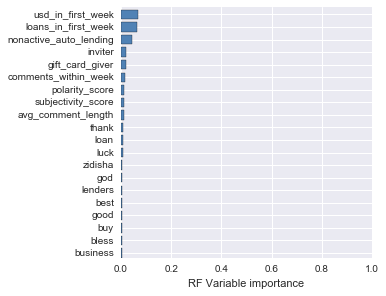

In [101]:
font = {'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

importances = rf.feature_importances_
indices = np.argsort(importances)[::1]
indices = indices[-20:]
importances = importances[indices]
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

mpl_fig.set_figwidth(4.5)
mpl_fig.set_figheight(4.5)


N = len(importances)
y_vals = importances
ind = np.arange(N)    # the x locations for the groups
width = 0.75       # the width of the bars: can also be len(x) sequence

p1 = ax.barh(ind, y_vals, width, color=(80.0/256, 131.0/256, 182.0/256))
ax.set_xlabel('RF Variable importance')
#ax.set_xlabel('Number of loans')
#ax.set_title('Number of loans')

ax.set_yticks(ind + width/2.)
ax.set_xticks(np.arange(0.0, 1.001, 0.2))
ax.set_yticklabels(list(X_train.columns[indices]))
plt.savefig('RandomForest.pdf', bbox_inches='tight')

## Explore correlation among most predictive features

In [102]:
a = ['retained']
b = X_train.columns[indices].tolist()
for i in range(0,len(b)):
    a.append(b[i])
lenders_df.loc[(lenders_df['never_uploaded']==0) & (lenders_df['comments_within_week']!=0),a].corr()

,retained,business,bless,buy,good,best,lenders,god,zidisha,luck,loan,thank,avg_comment_length,subjectivity_score,polarity_score,comments_within_week,gift_card_giver,inviter,nonactive_auto_lending,loans_in_first_week
retained,1.000000,0.051033,0.037586,-0.031883,0.056637,0.069586,0.007549,0.040657,0.040352,0.079111,0.025208,0.024810,-0.022543,-0.003816,0.026682,0.039899,0.155652,0.130957,0.169297,0.030586
business,0.051033,1.000000,0.661781,0.534913,0.766592,0.656575,0.794529,0.676744,0.753553,0.534818,0.833179,0.781315,0.096008,0.035151,0.011234,0.839546,0.025460,0.057104,0.065218,0.684208
bless,0.037586,0.661781,1.000000,0.513815,0.619744,0.612140,0.749816,0.975170,0.658119,0.405746,0.709482,0.766463,0.002677,0.018359,-0.020095,0.782502,0.010626,0.015314,0.076671,0.560005
buy,-0.031883,0.534913,0.513815,1.000000,0.430975,0.304304,0.640044,0.503652,0.542082,0.193656,0.622331,0.703406,0.064914,-0.013983,-0.064825,0.604323,0.028306,-0.046791,0.081377,0.616187
good,0.056637,0.766592,0.619744,0.430975,1.000000,0.601149,0.746244,0.630780,0.703848,0.727248,0.772540,0.720112,0.012340,0.088603,0.075335,0.824007,0.021499,0.068142,0.085441,0.599224
best,0.069586,0.656575,0.612140,0.304304,0.601149,1.000000,0.615260,0.616162,0.582040,0.488843,0.618162,0.619439,-0.003416,0.035609,0.157468,0.717960,0.035842,0.068861,0.064034,0.439093
lenders,0.007549,0.794529,0.749816,0.640044,0.746244,0.615260,1.000000,0.751143,0.845136,0.453034,0.917271,0.911811,0.019367,0.006109,-0.055300,0.921139,0.010822,0.019989,0.090353,0.745181
god,0.040657,0.676744,0.975170,0.503652,0.630780,0.616162,0.751143,1.000000,0.665048,0.410209,0.713529,0.766847,0.011076,0.022071,-0.019326,0.786080,0.015451,0.017561,0.073920,0.560455
zidisha,0.040352,0.753553,0.658119,0.542082,0.703848,0.582040,0.845136,0.665048,1.000000,0.439283,0.868715,0.823441,0.087779,0.008999,-0.057522,0.859328,0.006968,0.046399,0.087924,0.684289
luck,0.079111,0.534818,0.405746,0.193656,0.727248,0.488843,0.453034,0.410209,0.439283,1.000000,0.490551,0.449498,-0.075484,0.097744,0.162357,0.587084,0.044119,0.076612,0.070747,0.332750


In [103]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::1]
indices = indices[-20:]
X_100_train = X_train[X_train.columns[indices]]
X_100_test = X_test[X_test.columns[indices]]

In [104]:
rf = RandomForestClassifier(n_estimators=2000,max_depth=8)
rf.fit(X_100_train, y_train)
predicted = rf.predict(X_100_test)
probs = rf.predict_proba(X_100_test)
# check the accuracy on the training set
rf.score(X_100_train, y_train)


0.73620814261623702

In [105]:
print "Accuracy on test set is: " + str(metrics.accuracy_score(y_test, predicted))
print "Precision is: " + str(metrics.precision_score(y_test, predicted))
print "Recall is: " + str(metrics.recall_score(y_test, predicted))
print "Area under ROC-curve is: " + str(metrics.roc_auc_score(y_test, probs[:, 1]))

Accuracy on test set is: 0.656179775281
Precision is: 0.639842983317
Recall is: 0.726867335563
Area under ROC-curve is: 0.709468203436


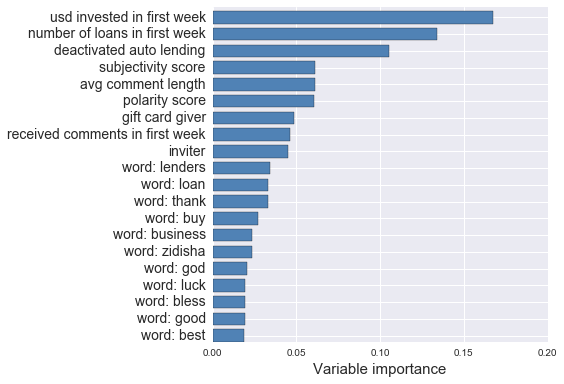

In [106]:
font = {'weight' : 'normal',
        'size'   : 30}

plt.rc('font', **font)

importances = rf.feature_importances_
indices = np.argsort(importances)[::1]
indices = indices[-20:]
importances = importances[indices]
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

mpl_fig.set_figwidth(6)
mpl_fig.set_figheight(6)


N = len(importances)
y_vals = importances
ind = np.arange(N)    # the x locations for the groups
width = 0.75       # the width of the bars: can also be len(x) sequence

p1 = ax.barh(ind, y_vals, width, color=(80.0/256, 131.0/256, 182.0/256))
ax.set_xlabel('Variable importance', fontsize=15)
#ax.set_xlabel('Number of loans')
#ax.set_title('Number of loans')
cleaned_names = ['word: best',
 'word: good',
 'word: bless',
 'word: luck',
 'word: god',
 'word: zidisha',
 'word: business',
 'word: buy',
 'word: thank',
 'word: loan',
 'word: lenders',
 'inviter',
 'received comments in first week',
 'gift card giver',
 'polarity score',
 'avg comment length',
 'subjectivity score',
 'deactivated auto lending',
 'number of loans in first week',
 'usd invested in first week']
ax.set_yticks(ind + width/2.)
ax.set_xticks(np.arange(0.0, 0.2001, 0.05))
#ax.set_yticklabels(list(X_100_train.columns[indices]))
ax.set_yticklabels(cleaned_names, fontsize=14)
#ax.ylabel('ylabel', fontsize=18)
plt.savefig('RandomForest.pdf', bbox_inches='tight')

In [107]:
#from seaborn import load_dataset
#ax = barplot(x="day", y="total_bill", data=y_vals)
#tips = load_dataset("tips")
list(X_100_train.columns[indices])

[u'good',
 u'best',
 u'luck',
 u'bless',
 u'god',
 u'business',
 u'zidisha',
 u'buy',
 u'thank',
 u'loan',
 u'lenders',
 'inviter',
 'comments_within_week',
 'gift_card_giver',
 'polarity_score',
 'subjectivity_score',
 'avg_comment_length',
 'nonactive_auto_lending',
 'loans_in_first_week',
 'usd_in_first_week']

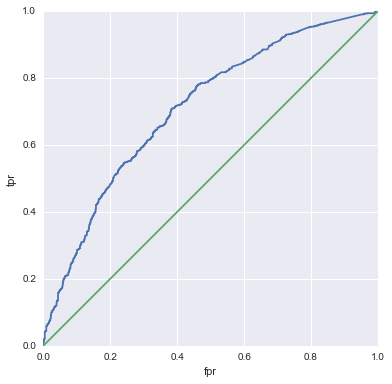

In [108]:
preds = rf.predict_proba(X_100_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))


mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

mpl_fig.set_figwidth(6)
mpl_fig.set_figheight(6)

ax.plot(df['fpr'],df['tpr'])
ax.plot([0,1],[0,1])
ax.set_xlabel('fpr')
ax.set_ylabel('tpr')
plt.savefig('ROCcurve.pdf', bbox_inches='tight')

## Random forest classifier with only comment features

In [109]:
rf2 = RandomForestClassifier(n_estimators=100,max_depth=5)

rf2.fit(X_train2, y_train)
predicted2 = rf2.predict(X_test2)

# check the accuracy on the training set
rf2.score(X_train2, y_train)


0.61430980486629727

In [110]:
print "Accuracy on test set is: " + str(metrics.accuracy_score(y_test, predicted2))
print "Precision is: " + str(metrics.precision_score(y_test, predicted2))
print "Recall is: " + str(metrics.recall_score(y_test, predicted2))
print "Area under ROC-curve is: " + str(metrics.roc_auc_score(y_test, predicted2))

Accuracy on test set is: 0.541573033708
Precision is: 0.545150501672
Recall is: 0.545150501672
Area under ROC-curve is: 0.54154467326


In [111]:
float(sum(y_test == 1)) / (sum(y_test == 1) + sum(y_test == 0))

0.5039325842696629

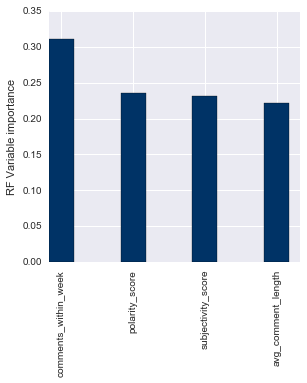

In [112]:
importances = rf2.feature_importances_
indices = np.argsort(importances)[::-1]

mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

mpl_fig.set_figwidth(4.5)
mpl_fig.set_figheight(4.5)


N = len(importances)
y_vals = importances
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = ax.bar(ind, y_vals[indices], width, color=(0.0/256, 51.0/256, 102.0/256))
ax.set_ylabel('RF Variable importance')
#ax.set_xlabel('Number of loans')
#ax.set_title('Number of loans')

ax.set_xticks(ind + width/2.)
#ax.set_yticks(np.arange(0.0, 0.1, 1.0))
ax.set_xticklabels(list(X_train2.columns[indices]),rotation=90)
plt.savefig('RandomForest.pdf', bbox_inches='tight')

## Correlations of features

In [113]:
X_train2.cov()

,comments_within_week,polarity_score,subjectivity_score,avg_comment_length
comments_within_week,1.087637,-0.022957,-0.004871,0.005274
polarity_score,-0.022957,0.971048,0.549564,-0.107632
subjectivity_score,-0.004871,0.549564,0.981463,0.167694
avg_comment_length,0.005274,-0.107632,0.167694,1.017543


In [114]:
X_train2.corr()

,comments_within_week,polarity_score,subjectivity_score,avg_comment_length
comments_within_week,1.000000,-0.022339,-0.004715,0.005013
polarity_score,-0.022339,1.000000,0.562938,-0.108279
subjectivity_score,-0.004715,0.562938,1.000000,0.167804
avg_comment_length,0.005013,-0.108279,0.167804,1.000000


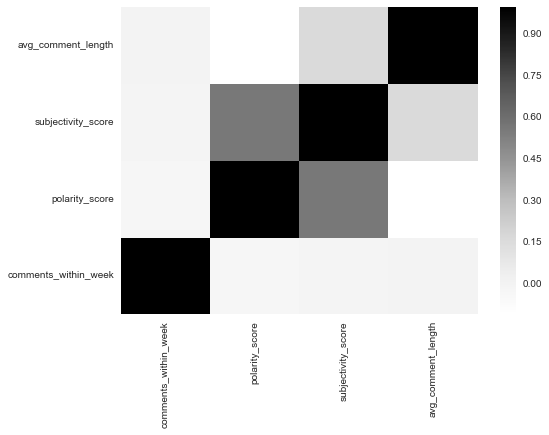

In [115]:
plt.pcolor(X_train2.corr())
plt.yticks(np.arange(0.5, len(X_train2.columns), 1), X_train2.columns)
plt.xticks(np.arange(0.5, len(X_train2.columns), 1), X_train2.columns,rotation=90)
plt.colorbar()
#plt.set_xticklabels(list(X_train.columns[indices]),rotation=90)
plt.savefig('VariableCorrelations.pdf', bbox_inches='tight')


## Exploring and visualizing the comment data

In [116]:
X.columns

Index([               u'inviter',              u'gift_card',
              u'gift_card_giver', u'nonactive_auto_lending',
          u'loans_in_first_week',      u'usd_in_first_week',
         u'comments_within_week',         u'polarity_score',
           u'subjectivity_score',     u'avg_comment_length',
       ...
                         u'yang',                   u'year',
                        u'years',                    u'yes',
                    u'yesterday',                    u'yet',
                        u'young',                u'zidisha',
                 u'invited_orig',                u'invited'],
      dtype='object', length=1011)

In [117]:
test_df = lenders_df.loc[:,('polarity_score','subjectivity_score')]

In [118]:
test_df['retained'] = y

In [119]:
test_df = test_df.drop('polarity_score',1)

In [120]:
test_df.subjectivity_score[:10]

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8     NaN
9    0.15
Name: subjectivity_score, dtype: float64

In [121]:
test_df.loc[test_df.loc[:,'subjectivity_score'] > ( test_df.subjectivity_score.median() + 2*test_df.subjectivity_score.std() ),'subjectivity_score'] = test_df.subjectivity_score.median() + 2*test_df.subjectivity_score.std()
test_df.loc[test_df.loc[:,'subjectivity_score'] < ( test_df.subjectivity_score.median() - 2*test_df.subjectivity_score.std() ),'subjectivity_score'] = test_df.subjectivity_score.median() - 2*test_df.subjectivity_score.std()

In [122]:
aaa = pd.cut(test_df.subjectivity_score.as_matrix(),3)

In [123]:
#test_df.retained[aaa==aaa.categories[0]]

In [124]:
retain_vec = [0]*3
std_vec = [0]*3
for i in range(0,3):
    vec = test_df.retained[aaa==aaa.categories[i]]
    retain_vec[i] = float(sum(vec==1)) / (sum(vec==1) + sum(vec==0))
    std_vec[i] = (np.sqrt((sum(vec==1) + sum(vec==0)) * retain_vec[i] * (1- retain_vec[i]) ) / (sum(vec==1) + sum(vec==0)) )


In [125]:
retain_vec

[0.5338189386056191, 0.5519930675909879, 0.5242030696576151]

In [126]:
test_df.subjectivity_score.median()

0.3962277116822572

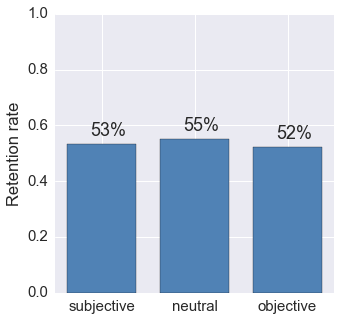

In [127]:
sns.set_context("notebook", font_scale=1.5)

mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

mpl_fig.set_figwidth(5)
mpl_fig.set_figheight(5)

N = 3
y_vals = retain_vec
ind = np.arange(N)    # the x locations for the groups
width = 0.75       # the width of the bars: can also be len(x) sequence

#p1 = ax.bar(ind, y_vals, width, color=(0.2588,0.4433,1.0), align='center')
#p1 = ax.bar(ind, y_vals, width, color=(0.0/256, 51.0/256, 102.0/256), align='center')
p1 = ax.bar(ind, y_vals, width, color=(80.0/256, 131.0/256, 182.0/256), align='center')
ax.set_ylabel('Retention rate')

ax.set_xticks(ind)# + width/2.)
ax.set_yticks(np.arange(0.0, 1.001, 0.2))
aaa.categories

#labels = ['[]']*len(aaa.categories)
#for i in range(0,len(aaa.categories)):
#    labels[i] = aaa.categories[i]#labels[0] = '[0, 0.192]'
#labels[0] = '[0.0, 0.192]'
#labels[len(aaa.categories)-1] = '(0.616,1]'
labels = ['subjective','neutral','objective']
ax.set_xticklabels(labels)
ax.text(ax.patches[0].get_x() + width*1/3,ax.patches[0].get_height() + 0.03,str(int(100*y_vals[0])) + '%')
ax.text(ax.patches[1].get_x() + width*1/3,ax.patches[1].get_height() + 0.03,str(int(100*y_vals[1])) + '%')
ax.text(ax.patches[2].get_x() + width*1/3,ax.patches[2].get_height() + 0.03,str(int(100*y_vals[2])) + '%')


plt.savefig('comment_subjectivity.pdf', bbox_inches='tight')


In [128]:
test_df = lenders_df.loc[:,('polarity_score','subjectivity_score')]

In [129]:
test_df['retained'] = y

In [130]:
test_df = test_df.drop('subjectivity_score',1)

In [131]:
test_df.loc[test_df.loc[:,'polarity_score'] > ( test_df.polarity_score.median() + 2*test_df.polarity_score.std() ),'polarity_score'] = test_df.polarity_score.median() + 2*test_df.polarity_score.std()
test_df.loc[test_df.loc[:,'polarity_score'] < ( test_df.polarity_score.median() - 2*test_df.polarity_score.std() ),'polarity_score'] = test_df.polarity_score.median() - 2*test_df.polarity_score.std()

In [132]:
aaa = pd.cut(test_df.polarity_score.as_matrix(),3)

In [133]:
retain_vec = [0]*3
std_vec = [0]*3
for i in range(0,3):
    vec = test_df.retained[aaa==aaa.categories[i]]
    retain_vec[i] = float(sum(vec==1)) / (sum(vec==1) + sum(vec==0))
    std_vec[i] = (np.sqrt((sum(vec==1) + sum(vec==0)) * retain_vec[i] * (1- retain_vec[i]) ) / (sum(vec==1) + sum(vec==0)) )


In [134]:
aaa.categories[2]

'(0.446, 0.708]'

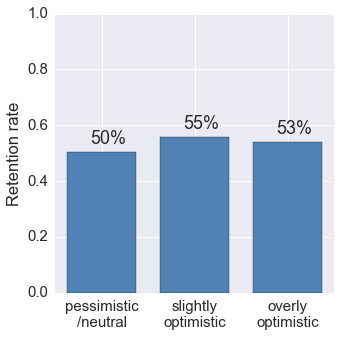

In [135]:
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

mpl_fig.set_figwidth(5)
mpl_fig.set_figheight(5)

N = 3
y_vals = retain_vec
ind = np.arange(N)    # the x locations for the groups
width = 0.75       # the width of the bars: can also be len(x) sequence

#p1 = ax.bar(ind, y_vals, width, color=(0.2588,0.4433,1.0), align='center')
#p1 = ax.bar(ind, y_vals, width, color=(0.0/256, 51.0/256, 102.0/256), align='center')
p1 = ax.bar(ind, y_vals, width, color=(80.0/256, 131.0/256, 182.0/256), align='center')
ax.set_ylabel('Retention rate')

ax.set_xticks(ind)# + width/2.)
ax.set_yticks(np.arange(0.0, 1.001, 0.2))
aaa.categories

#labels = ['[]']*len(aaa.categories)
#for i in range(0,len(aaa.categories)):
#    labels[i] = aaa.categories[i]#labels[0] = '[0, 0.192]'
#labels[0] = '[0.0, 0.192]'
#labels[len(aaa.categories)-1] = '(0.616,1]'
labels = ['pessimistic\n/neutral','slightly\noptimistic','overly\noptimistic']
ax.set_xticklabels(labels)
ax.text(ax.patches[0].get_x() + width*1/3,ax.patches[0].get_height() + 0.03,str(int(100*y_vals[0])) + '%')
ax.text(ax.patches[1].get_x() + width*1/3,ax.patches[1].get_height() + 0.03,str(int(100*y_vals[1])) + '%')
ax.text(ax.patches[2].get_x() + width*1/3,ax.patches[2].get_height() + 0.03,str(int(100*y_vals[2])) + '%')


plt.savefig('comment_polarity.pdf', bbox_inches='tight')


In [136]:
test_df = lenders_df.loc[:,('avg_comment_length','subjectivity_score')]

In [137]:
test_df['retained'] = y

In [138]:
test_df = test_df.drop('subjectivity_score',1)

In [139]:
test_df.loc[test_df.loc[:,'avg_comment_length'] > ( test_df.avg_comment_length.median() + 2*test_df.avg_comment_length.std() ),'avg_comment_length'] = test_df.avg_comment_length.median() + 2*test_df.avg_comment_length.std()
test_df.loc[test_df.loc[:,'avg_comment_length'] < ( test_df.avg_comment_length.median() - 2*test_df.avg_comment_length.std() ),'avg_comment_length'] = test_df.avg_comment_length.median() - 2*test_df.avg_comment_length.std()

In [140]:
aaa = pd.cut(test_df.avg_comment_length.as_matrix(),4)

In [141]:
retain_vec = [0]*4
std_vec = [0]*4
for i in range(0,4):
    vec = test_df.retained[aaa==aaa.categories[i]]
    retain_vec[i] = float(sum(vec==1)) / (sum(vec==1) + sum(vec==0))
    std_vec[i] = (np.sqrt((sum(vec==1) + sum(vec==0)) * retain_vec[i] * (1- retain_vec[i]) ) / (sum(vec==1) + sum(vec==0)) )


In [142]:
aaa.categories[2]

'(49.994, 74.99]'

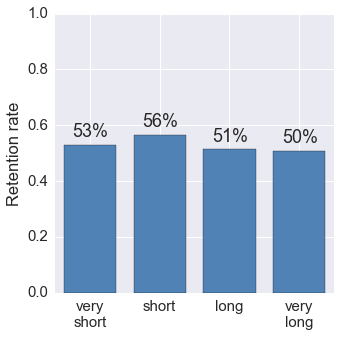

In [143]:
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

mpl_fig.set_figwidth(5)
mpl_fig.set_figheight(5)

N = 4
y_vals = retain_vec
ind = np.arange(N)    # the x locations for the groups
width = 0.75       # the width of the bars: can also be len(x) sequence

#p1 = ax.bar(ind, y_vals, width, color=(0.2588,0.4433,1.0), align='center')
#p1 = ax.bar(ind, y_vals, width, color=(0.0/256, 51.0/256, 102.0/256), align='center')
p1 = ax.bar(ind, y_vals, width, color=(80.0/256, 131.0/256, 182.0/256), align='center')
ax.set_ylabel('Retention rate')

ax.set_xticks(ind)# + width/2.)
ax.set_yticks(np.arange(0.0, 1.001, 0.2))
aaa.categories

#labels = ['[]']*len(aaa.categories)
#for i in range(0,len(aaa.categories)):
#    labels[i] = aaa.categories[i]#labels[0] = '[0, 0.192]'
#labels[0] = '[0.0, 0.192]'
#labels[len(aaa.categories)-1] = '(0.616,1]'
labels = ['very\nshort','short','long','very\nlong']
ax.set_xticklabels(labels)
ax.text(ax.patches[0].get_x() + width*1/6,ax.patches[0].get_height() + 0.03,str(int(100*y_vals[0])) + '%')
ax.text(ax.patches[1].get_x() + width*1/6,ax.patches[1].get_height() + 0.03,str(int(100*y_vals[1])) + '%')
ax.text(ax.patches[2].get_x() + width*1/6,ax.patches[2].get_height() + 0.03,str(int(100*y_vals[2])) + '%')
ax.text(ax.patches[3].get_x() + width*1/6,ax.patches[3].get_height() + 0.03,str(int(100*y_vals[3])) + '%')


plt.savefig('comment_length.pdf', bbox_inches='tight')


In [144]:
number_of_words = borrower_comments_df.loc[:,'message'].apply(nltk.word_tokenize).apply(len)

In [145]:
lenders_df['distance_score'] = (lenders_df['polarity_score']-lenders_df['polarity_score'].mean()) + (lenders_df['subjectivity_score']-lenders_df['subjectivity_score'].mean())

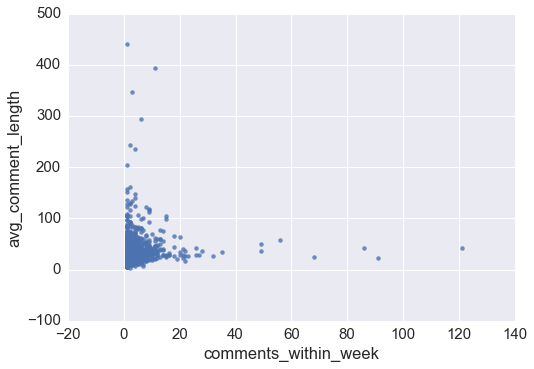

In [146]:
retained_points = lenders_df.loc[lenders_df['retained']==1,('comments_within_week','avg_comment_length')]
#retained_points = retained_points[retained_points.distance_score.notnull()]
ax = sns.regplot(x="comments_within_week", y="avg_comment_length", data=retained_points[:1000],fit_reg=False)

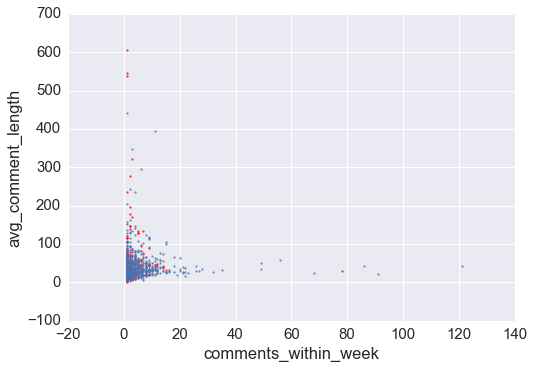

In [147]:
notretained_points = lenders_df.loc[lenders_df['retained']==0,('comments_within_week','avg_comment_length')]
#notretained_points = notretained_points[notretained_points.distance_score.notnull()]
ax = sns.regplot(x="comments_within_week", y="avg_comment_length", data=notretained_points[:1000],fit_reg=False,color='red',marker='.')
ax = sns.regplot(x="comments_within_week", y="avg_comment_length", data=retained_points[:1000],fit_reg=False,marker='.')


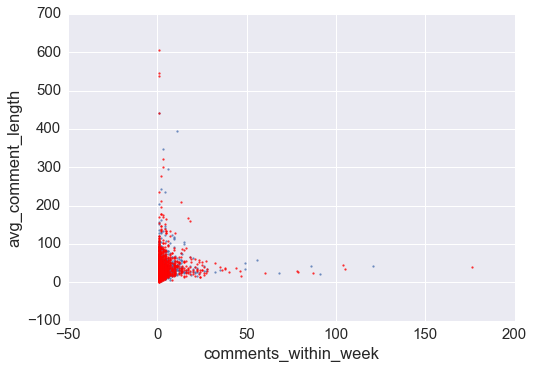

In [148]:
notretained_points = lenders_df.loc[lenders_df['retained']==0,('comments_within_week','avg_comment_length')]
notretained_points = notretained_points[notretained_points.avg_comment_length.notnull()]
ax = sns.regplot(x="comments_within_week", y="avg_comment_length", data=retained_points[:1000],fit_reg=False,marker='.')
ax = sns.regplot(x="comments_within_week", y="avg_comment_length", data=notretained_points[:1000],fit_reg=False,color='red',marker='.')


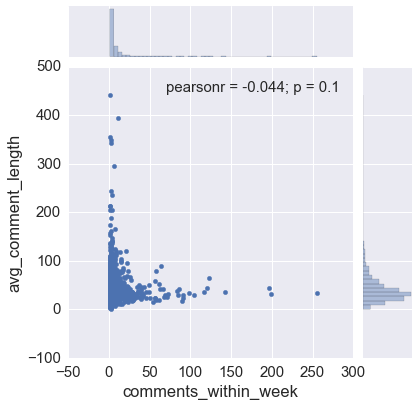

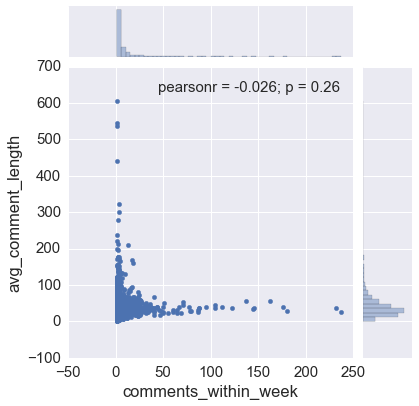

In [149]:
ax = sns.jointplot(x="comments_within_week", y="avg_comment_length", data=retained_points[:2000]);
ax = sns.jointplot(x="comments_within_week", y="avg_comment_length", data=notretained_points[:2000]);

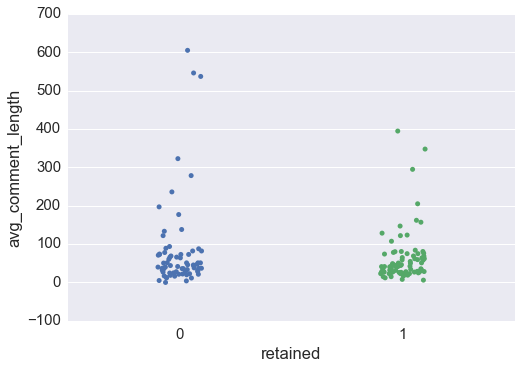

In [150]:
sns.stripplot(x="retained", y="avg_comment_length", data=lenders_df[:500],jitter=True);

In [151]:
retained_df = lenders_df[lenders_df.retained==1]
notretained_df = lenders_df[lenders_df.retained==0]
retained_df.loc[:,('norm_avg_comment_length')] = retained_df.loc[:,('avg_comment_length')] / retained_df.loc[:,('avg_comment_length')].sum()
notretained_df.loc[:,('norm_avg_comment_length')] = notretained_df.loc[:,('avg_comment_length')] / notretained_df.loc[:,('avg_comment_length')].sum()

/Users/eriksjoeland/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/eriksjoeland/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [152]:
retained_test = retained_df.avg_comment_length[retained_df.avg_comment_length.notnull()]
notretained_test = notretained_df.avg_comment_length[notretained_df.avg_comment_length.notnull()]

In [153]:
retained_test = retained_test[retained_test < 120]
notretained_test = notretained_test[notretained_test < 120]

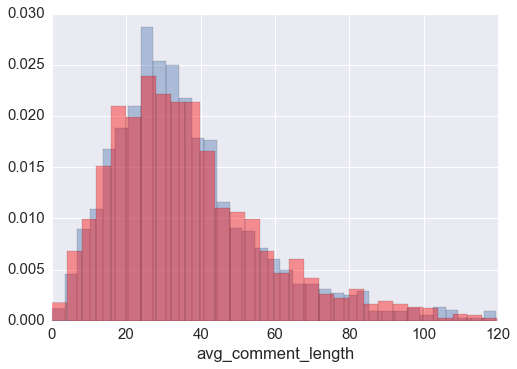

In [154]:
sns.distplot(retained_test,kde=False,norm_hist=True);
sns.distplot(notretained_test,kde=False,norm_hist=True,color='red');

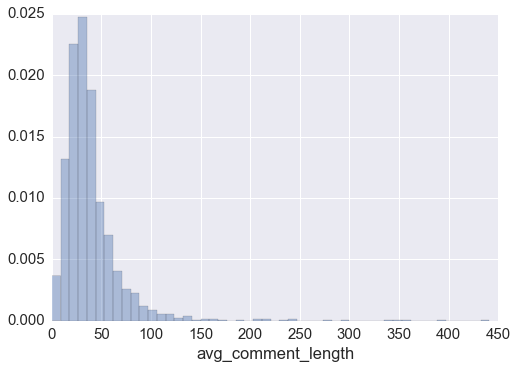

In [155]:
sns.distplot(retained_df.avg_comment_length[retained_df.avg_comment_length.notnull()],kde=False,norm_hist=True);


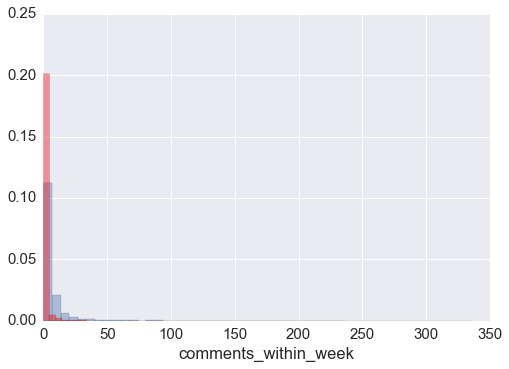

In [156]:
sns.distplot(retained_df.comments_within_week[retained_df.comments_within_week.notnull()],kde=False,norm_hist=True);
sns.distplot(notretained_df.comments_within_week[notretained_df.comments_within_week.notnull()],kde=False,norm_hist=True,color='red');

In [157]:
retained_test = retained_df.comments_within_week[retained_df.comments_within_week.notnull()]
notretained_test = notretained_df.comments_within_week[notretained_df.comments_within_week.notnull()]
retained_test = retained_test[retained_test < 25]
notretained_test = notretained_test[notretained_test < 25]

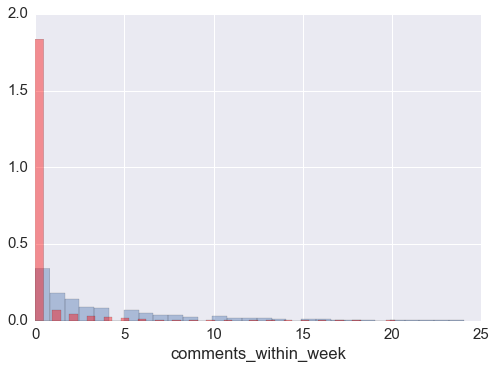

In [158]:
sns.distplot(retained_test,kde=False,norm_hist=True);
sns.distplot(notretained_test,kde=False,norm_hist=True,color='red');

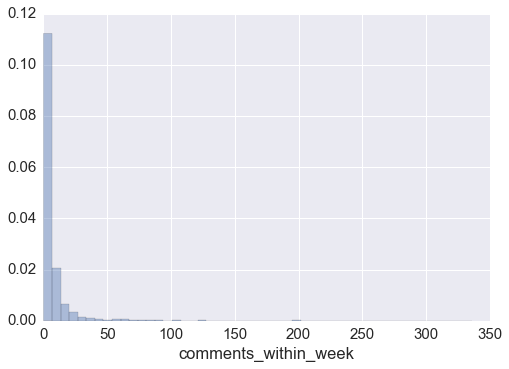

In [159]:
sns.distplot(retained_df.comments_within_week[retained_df.comments_within_week.notnull()],kde=False,norm_hist=True);

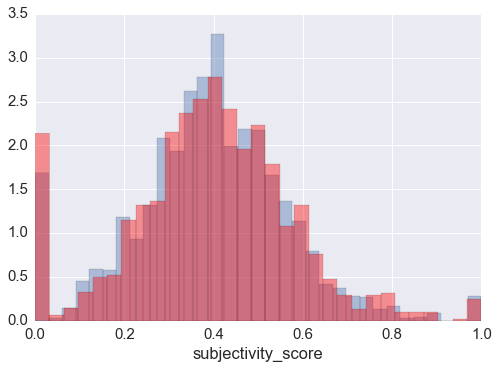

In [160]:
sns.distplot(retained_df.subjectivity_score[retained_df.subjectivity_score.notnull()],kde=False,norm_hist=True);
sns.distplot(notretained_df.subjectivity_score[notretained_df.subjectivity_score.notnull()],kde=False,norm_hist=True,color='red');

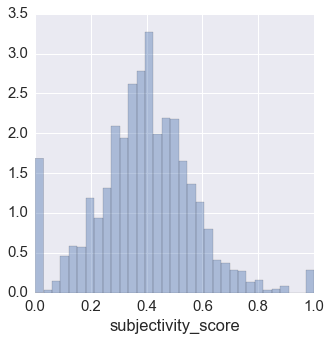

In [161]:
mpl_fig = plt.figure()
mpl_fig.set_figwidth(5)
mpl_fig.set_figheight(5)
ax = mpl_fig.add_subplot(1,1,1)
ax = sns.distplot(retained_df.subjectivity_score[retained_df.subjectivity_score.notnull()],kde=False,norm_hist=True);

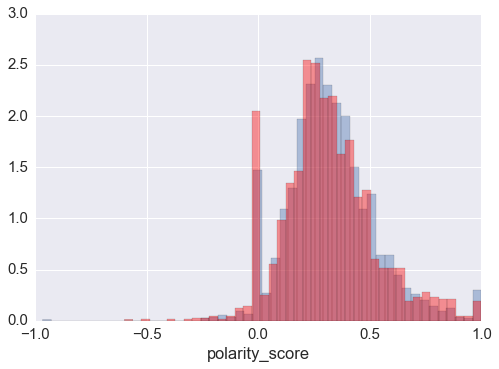

In [162]:
sns.distplot(retained_df.polarity_score[retained_df.polarity_score.notnull()],kde=False,norm_hist=True);
sns.distplot(notretained_df.polarity_score[notretained_df.polarity_score.notnull()],kde=False,norm_hist=True,color='red');

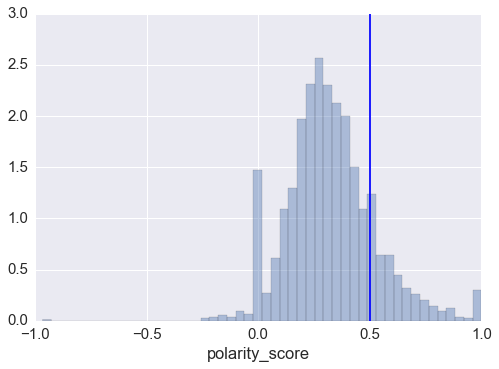

In [163]:
ax = sns.distplot(retained_df.polarity_score[retained_df.polarity_score.notnull()],kde=False,norm_hist=True);
ax.axvline(x=0.5)

In [164]:
#ax = s.hist()  # s is an instance of Series
#fig = ax.get_figure()
#fig.savefig('/path/to/figure.pdf')

In [165]:
polarity_vec = retained_df.polarity_score[retained_df.polarity_score.notnull()]
polarity_vec.to_csv('/Users/eriksjoeland/Desktop/Insight/Project/polarity_vec.csv')

In [166]:
subjectivity_vec = retained_df.subjectivity_score[retained_df.subjectivity_score.notnull()]
subjectivity_vec.to_csv('/Users/eriksjoeland/Desktop/Insight/Project/subjectivity_vec.csv')

In [167]:
comments_vec = retained_df.avg_comment_length[retained_df.avg_comment_length.notnull()]
comments_vec.to_csv('/Users/eriksjoeland/Desktop/Insight/Project/comments_vec.csv')

In [168]:
polarity_vec_in = pd.Series.from_csv('/Users/eriksjoeland/Desktop/Insight/Project/polarity_vec.csv')

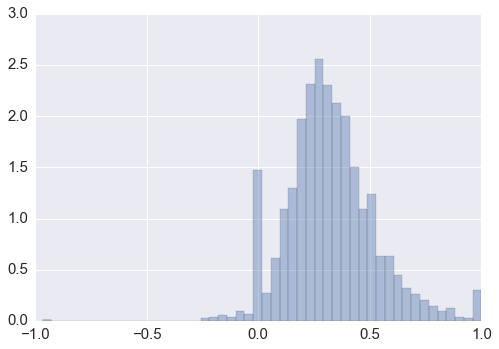

In [169]:
ax = sns.distplot(polarity_vec_in,kde=False,norm_hist=True);


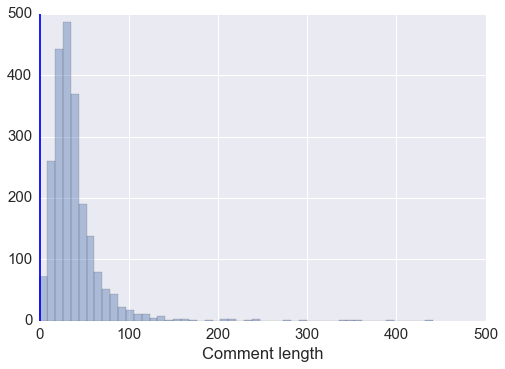

In [170]:
score_1 = 0.5
score_2 = 0.5
score_3 = 0.5
polarity_vec = pd.Series.from_csv('/Users/eriksjoeland/Desktop/Insight/flask_app/flaskexample/static/csv/polarity_vec.csv')
#  polarity_vec = pd.Series.from_csv('../static/csv/polarity_vec.csv')
ax1 = sns.distplot(polarity_vec,kde=False);
ax1.axvline(x=score_1)
fig1 = ax1.get_figure()
#fig1.savefig('/Users/eriksjoeland/Desktop/Insight/flask_app/flaskexample/static/img/polarity.pdf')
plt.cla()   # Clear axis
plt.clf()   # Clear figure
plt.close() # Close a figure window

subjectivity_vec = pd.Series.from_csv('/Users/eriksjoeland/Desktop/Insight/flask_app/flaskexample/static/csv/subjectivity_vec.csv')
#  polarity_vec = pd.Series.from_csv('../static/csv/polarity_vec.csv')
ax2 = sns.distplot(subjectivity_vec,kde=False,norm_hist=True);
ax2.axvline(x=score_2)
fig2 = ax2.get_figure()
#fig2.savefig('/Users/eriksjoeland/Desktop/Insight/flask_app/flaskexample/static/img/subjectivity.pdf')
plt.cla()   # Clear axis
plt.clf()   # Clear figure
plt.close() # Close a figure window

comments_vec = pd.Series.from_csv('/Users/eriksjoeland/Desktop/Insight/flask_app/flaskexample/static/csv/comments_vec.csv')
#  polarity_vec = pd.Series.from_csv('../static/csv/polarity_vec.csv')
ax3 = sns.distplot(comments_vec,kde=False);
ax3.axvline(x=score_3)
ax3.set_xlabel('Comment length')
ax3.set_xticks(np.arange(0.0, 500.001, 100))

fig3 = ax3.get_figure()
#fig3.savefig('/Users/eriksjoeland/Desktop/Insight/flask_app/flaskexample/static/img/comments.pdf')


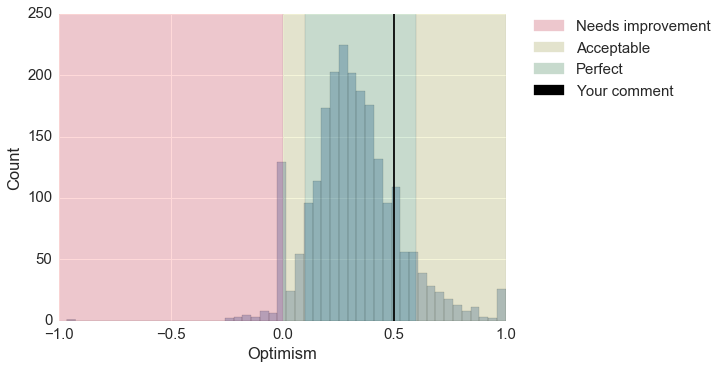

In [171]:
red_patch = mpatches.Patch(color='#edc7cd', label='Needs improvement')
yellow_patch = mpatches.Patch(color='#e3e3cd', label='Acceptable')
green_patch = mpatches.Patch(color='#c7dacd', label='Perfect')
black_patch = mpatches.Patch(color='#000000', label='Your comment')



ax1 = sns.distplot(polarity_vec,kde=False);
ax1.axvline(x=score_1,color='black')
ax1.set_xlabel('Optimism')
ax1.set_ylabel('Count')
ax1.axvspan(0.1, 0.6, facecolor='g', alpha=0.15)
ax1.axvspan(0, 0.1, facecolor='y', alpha=0.15)
ax1.axvspan(0.6, 1, facecolor='y', alpha=0.15)
ax1.axvspan(-1,0, facecolor='r', alpha=0.15)
lgd = ax1.legend(handles=[red_patch,yellow_patch,green_patch,black_patch], bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.)
#  ax1.legend(handles=[red_patch], bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.)
fig1 = ax1.get_figure()
polarity_name = 'polarity.png'
fig1.savefig('/Users/eriksjoeland/Desktop/Insight/flask_app/flaskexample/' + polarity_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
